 # **Trabalho Individual 5 (Aprendizado Profundo)**

 Para realizar o carregamento da base utilizado nos experimentos, realizar o treinamento e os testes com os modelos, utilizei o framework Pytorch baseado no código do [Tutorial Pytorch](https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/). Este é o código principal:

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from matplotlib import pyplot as plt

lista_alexnet = []
lista_vgg = []
lista_inception = []
lista_resnet = []
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 5
learning_rate = 0.001

# Image preprocessing modules
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform_train,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transform_test)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64,
                                          shuffle=False)

# No caso da inception, é necessário fazer alterações no tamanho da imagem

transform_train_inception = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test_inception = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# CIFAR-10 dataset inception
train_dataset_inception = torchvision.datasets.CIFAR10(root='../../data/',
                                                       train=True,
                                                       transform=transform_train_inception,
                                                       download=True)

test_dataset_inception = torchvision.datasets.CIFAR10(root='../../data/',
                                                      train=False,
                                                      transform=transform_test)

# Data loader
train_loader_inception = torch.utils.data.DataLoader(dataset=train_dataset_inception,
                                                     batch_size=64,
                                                     shuffle=True)

test_loader_inception = torch.utils.data.DataLoader(dataset=test_dataset_inception,
                                                    batch_size=64,
                                                    shuffle=False)


def modelo(tipo, pretrained):
    if tipo == 'AlexNet':
        model = models.alexnet(pretrained=pretrained)
        num_classes = 10
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif tipo == 'Inception v3':
        model = models.inception_v3(pretrained=pretrained)
        model.aux_logits = False
    elif tipo == 'Vgg16':
        model = models.vgg16(pretrained=pretrained)
        num_classes = 10
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif tipo == 'ResNet18':
        model = models.resnet18(pretrained=pretrained)
        num_classes = 10
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    if torch.cuda.is_available():
        model.cuda()
    return model


def aprendizado(model):
    # Loss and optimizer
    model_name = model.__class__.__name__
    if model_name == 'AlexNet':
        lista = lista_alexnet
        train = train_loader
        test = test_loader
    elif model_name == 'VGG':
        lista = lista_vgg
        train = train_loader
        test = test_loader
    elif model_name == 'Inception3':
        lista = lista_inception
        train = train_loader_inception
        test = test_loader_inception
    elif model_name == 'ResNet':
        lista = lista_resnet
        train = train_loader
        test = test_loader
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # For updating learning rate
    def update_lr(optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Train the model
    total_step = len(train)
    curr_lr = learning_rate
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f"Epoca [{epoch + 1}/{num_epochs}], Passo [{i + 1}/{total_step}] Loss: {loss.item():.4f}")

        # Decay learning rate
        if (epoch + 1) % 20 == 0:
            curr_lr /= 3
            update_lr(optimizer, curr_lr)
        # Test the model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            lista.append(accuracy)
            print(f'Acuracia do modelo {model_name}: {accuracy} %')


# apenas as 3 ultimas camadas serao descongeladas
def descongela_ultimas_camadas(modelo):
    camadas = sum(1 for e in modelo.parameters())
    for param in modelo.parameters():
        if camadas <= 3:
            try:
                param.requires_grad = False
            except:
                pass


def plota_grafico(acuracias_alexnet, acuracias_inception, acuracias_vgg, acuracias_resnet):
    q_acuracia = [1, 2, 3, 4, 5]
    # Plota o grafico
    plt.plot(q_acuracia, acuracias_alexnet, marker='o')
    plt.plot(q_acuracia, acuracias_inception, marker='*')
    plt.plot(q_acuracia, acuracias_vgg, marker='s')
    plt.plot(q_acuracia, acuracias_resnet, marker='^')
    plt.ylim([50, 100])
    plt.legend(['AlexNet', 'Inception', 'Vgg', 'Resnet'])
    plt.title('Acuracia X Epoca')
    plt.xlabel('Epoca')
    plt.ylabel('Acuracia')
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


1-Comparar 4 redes CNN pré-treinadas na Imagenet (AlexNet, Inception v3, Vgg16 e ResNet18) e plotar seus resultados de acurácia para CIFAR10. Importante saber que vocês precisarão substituir a última camada de cada CNN com uma camada com apenas 10 classes;

In [ ]:
alexnet = modelo('AlexNet', True)
aprendizado(alexnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoca [1/5], Passo [100/782] Loss: 1.1581
Epoca [1/5], Passo [200/782] Loss: 0.9580
Epoca [1/5], Passo [300/782] Loss: 0.6005
Epoca [1/5], Passo [400/782] Loss: 0.6393
Epoca [1/5], Passo [500/782] Loss: 0.7087
Epoca [1/5], Passo [600/782] Loss: 0.5260
Epoca [1/5], Passo [700/782] Loss: 0.6313
Acuracia do modelo AlexNet: 80.79 %
Epoca [2/5], Passo [100/782] Loss: 0.4907
Epoca [2/5], Passo [200/782] Loss: 0.5653
Epoca [2/5], Passo [300/782] Loss: 0.5510
Epoca [2/5], Passo [400/782] Loss: 0.2925
Epoca [2/5], Passo [500/782] Loss: 0.5340
Epoca [2/5], Passo [600/782] Loss: 0.4135
Epoca [2/5], Passo [700/782] Loss: 0.4026
Acuracia do modelo AlexNet: 84.91 %
Epoca [3/5], Passo [100/782] Loss: 0.3360
Epoca [3/5], Passo [200/782] Loss: 0.4592
Epoca [3/5], Passo [300/782] Loss: 0.2945
Epoca [3/5], Passo [400/782] Loss: 0.4810
Epoca [3/5], Passo [500/782] Loss: 0.2723
Epoca [3/5], Passo [600/782] Loss: 0.5123
Epoca [3/5], Passo [700/782] Loss: 0.3623
Acuracia do modelo AlexNet: 85.88 %
Epoca [4/5

In [ ]:
inception = modelo('Inception v3', True)
aprendizado(inception)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoca [1/5], Passo [100/782] Loss: 4.7340
Epoca [1/5], Passo [200/782] Loss: 2.4254
Epoca [1/5], Passo [300/782] Loss: 1.5766
Epoca [1/5], Passo [400/782] Loss: 0.9810
Epoca [1/5], Passo [500/782] Loss: 0.7923
Epoca [1/5], Passo [600/782] Loss: 0.8939
Epoca [1/5], Passo [700/782] Loss: 0.9499
Acuracia do modelo Inception3: 75.67 %
Epoca [2/5], Passo [100/782] Loss: 0.2626
Epoca [2/5], Passo [200/782] Loss: 0.2003
Epoca [2/5], Passo [300/782] Loss: 0.2966
Epoca [2/5], Passo [400/782] Loss: 0.2686
Epoca [2/5], Passo [500/782] Loss: 0.5900
Epoca [2/5], Passo [600/782] Loss: 0.4086
Epoca [2/5], Passo [700/782] Loss: 0.1919
Acuracia do modelo Inception3: 89.06 %
Epoca [3/5], Passo [100/782] Loss: 0.2146
Epoca [3/5], Passo [200/782] Loss: 0.1002
Epoca [3/5], Passo [300/782] Loss: 0.2456
Epoca [3/5], Passo [400/782] Loss: 0.2393
Epoca [3/5], Passo [500/782] Loss: 0.1240
Epoca [3/5], Passo [600/782] Loss: 0.1320
Epoca [3/5], Passo [700/782] Loss: 0.1220
Acuracia do modelo Inception3: 90.77 %
E

In [ ]:
vgg = modelo('Vgg16', True)
aprendizado(vgg)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoca [1/5], Passo [100/782] Loss: 1.1666
Epoca [1/5], Passo [200/782] Loss: 0.5685
Epoca [1/5], Passo [300/782] Loss: 0.6128
Epoca [1/5], Passo [400/782] Loss: 0.3816
Epoca [1/5], Passo [500/782] Loss: 0.5205
Epoca [1/5], Passo [600/782] Loss: 0.5778
Epoca [1/5], Passo [700/782] Loss: 0.3412
Acuracia do modelo VGG: 86.23 %
Epoca [2/5], Passo [100/782] Loss: 0.4067
Epoca [2/5], Passo [200/782] Loss: 0.2873
Epoca [2/5], Passo [300/782] Loss: 0.3308
Epoca [2/5], Passo [400/782] Loss: 0.2661
Epoca [2/5], Passo [500/782] Loss: 0.2959
Epoca [2/5], Passo [600/782] Loss: 0.3030
Epoca [2/5], Passo [700/782] Loss: 0.0830
Acuracia do modelo VGG: 89.03 %
Epoca [3/5], Passo [100/782] Loss: 0.2438
Epoca [3/5], Passo [200/782] Loss: 0.4986
Epoca [3/5], Passo [300/782] Loss: 0.2482
Epoca [3/5], Passo [400/782] Loss: 0.2694
Epoca [3/5], Passo [500/782] Loss: 0.2830
Epoca [3/5], Passo [600/782] Loss: 0.3385
Epoca [3/5], Passo [700/782] Loss: 0.1953
Acuracia do modelo VGG: 90.12 %
Epoca [4/5], Passo [10

In [ ]:
resnet = modelo('ResNet18', True)
aprendizado(resnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoca [1/5], Passo [100/782] Loss: 1.8823
Epoca [1/5], Passo [200/782] Loss: 1.5465
Epoca [1/5], Passo [300/782] Loss: 1.2624
Epoca [1/5], Passo [400/782] Loss: 1.2108
Epoca [1/5], Passo [500/782] Loss: 0.9804
Epoca [1/5], Passo [600/782] Loss: 0.9060
Epoca [1/5], Passo [700/782] Loss: 0.8643
Acuracia do modelo ResNet: 78.09 %
Epoca [2/5], Passo [100/782] Loss: 0.3790
Epoca [2/5], Passo [200/782] Loss: 0.3099
Epoca [2/5], Passo [300/782] Loss: 0.4315
Epoca [2/5], Passo [400/782] Loss: 0.3880
Epoca [2/5], Passo [500/782] Loss: 0.3046
Epoca [2/5], Passo [600/782] Loss: 0.3310
Epoca [2/5], Passo [700/782] Loss: 0.4926
Acuracia do modelo ResNet: 88.5 %
Epoca [3/5], Passo [100/782] Loss: 0.2339
Epoca [3/5], Passo [200/782] Loss: 0.2488
Epoca [3/5], Passo [300/782] Loss: 0.2124
Epoca [3/5], Passo [400/782] Loss: 0.5410
Epoca [3/5], Passo [500/782] Loss: 0.3797
Epoca [3/5], Passo [600/782] Loss: 0.5054
Epoca [3/5], Passo [700/782] Loss: 0.3152
Acuracia do modelo ResNet: 88.64 %
Epoca [4/5], P

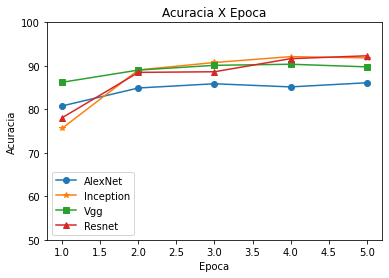

In [ ]:
plota_grafico([80.79,84.91,85.88,85.16,86.11],[75.67,89.06,90.77,92.12,91.83],[86.23,89.03,90.12,90.37,89.77],[78.09,88.5,88.64,91.65,92.31])

No caso do primeiro teste, pode se notar que com o passar das épocas, há uma dominância da rede Resnet e da Inception, apesar de apresentarem os piores resultados na primeira época. O melhor score ficou para ResNet, com 92.31 % na 5 época; o pior, para AlexNet com 86.11 %.

Limpeza das listas de acurácia.

In [ ]:
acuracias_alexnet = []
acuracias_vgg = []
acuracias_resnet = []

2-Utilizar das mesmas arquiteturas anteriores, mas agora vocês realizarão o FINETUNING de cada uma das redes descongelando as 3 últimas camadas. Plotar seus resultados de acurácia para CIFAR10;

In [ ]:
alexnet = modelo('AlexNet', True)
descongela_ultimas_camadas(alexnet)
aprendizado(alexnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoca [1/5], Passo [100/782] Loss: 1.0242
Epoca [1/5], Passo [200/782] Loss: 0.7494
Epoca [1/5], Passo [300/782] Loss: 0.7928
Epoca [1/5], Passo [400/782] Loss: 0.4595
Epoca [1/5], Passo [500/782] Loss: 0.4755
Epoca [1/5], Passo [600/782] Loss: 0.6416
Epoca [1/5], Passo [700/782] Loss: 0.7116
Acuracia do modelo AlexNet: 81.7 %
Epoca [2/5], Passo [100/782] Loss: 0.6860
Epoca [2/5], Passo [200/782] Loss: 0.3268
Epoca [2/5], Passo [300/782] Loss: 0.4588
Epoca [2/5], Passo [400/782] Loss: 0.4000
Epoca [2/5], Passo [500/782] Loss: 0.4885
Epoca [2/5], Passo [600/782] Loss: 0.4109
Epoca [2/5], Passo [700/782] Loss: 0.4627
Acuracia do modelo AlexNet: 84.08 %
Epoca [3/5], Passo [100/782] Loss: 0.3596
Epoca [3/5], Passo [200/782] Loss: 0.4315
Epoca [3/5], Passo [300/782] Loss: 0.4432
Epoca [3/5], Passo [400/782] Loss: 0.5189
Epoca [3/5], Passo [500/782] Loss: 0.5922
Epoca [3/5], Passo [600/782] Loss: 0.3169
Epoca [3/5], Passo [700/782] Loss: 0.4008
Acuracia do modelo AlexNet: 85.82 %
Epoca [4/5]

In [ ]:
inception = modelo('Inception v3', True)
descongela_ultimas_camadas(inception)
aprendizado(inception)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Epoca [1/5], Passo [100/782] Loss: 4.5346
Epoca [1/5], Passo [200/782] Loss: 2.2003
Epoca [1/5], Passo [300/782] Loss: 1.9074
Epoca [1/5], Passo [400/782] Loss: 0.9911
Epoca [1/5], Passo [500/782] Loss: 0.9427
Epoca [1/5], Passo [600/782] Loss: 1.1948
Epoca [1/5], Passo [700/782] Loss: 0.5621
Acuracia do modelo Inception3: 76.99 %
Epoca [2/5], Passo [100/782] Loss: 0.3838
Epoca [2/5], Passo [200/782] Loss: 0.2186
Epoca [2/5], Passo [300/782] Loss: 0.3623
Epoca [2/5], Passo [400/782] Loss: 0.3113
Epoca [2/5], Passo [500/782] Loss: 0.3203
Epoca [2/5], Passo [600/782] Loss: 0.0889
Epoca [2/5], Passo [700/782] Loss: 0.2167
Acuracia do modelo Inception3: 88.61 %
Epoca [3/5], Passo [100/782] Loss: 0.1502
Epoca [3/5], Passo [200/782] Loss: 0.3322
Epoca [3/5], Passo [300/782] Loss: 0.0632
Epoca [3/5], Passo [400/782] Loss: 0.2746
Epoca [3/5], Passo [500/782] Loss: 0.1822
Epoca [3/5], Passo [600/782] Loss: 0.0865
Epoca [3/5], Passo [700/782] Loss: 0.0160
Acuracia do modelo Inception3: 91.29 %
E

In [ ]:
vgg = modelo('Vgg16', True)
descongela_ultimas_camadas(vgg)
aprendizado(vgg)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoca [1/5], Passo [100/782] Loss: 1.2020
Epoca [1/5], Passo [200/782] Loss: 1.2037
Epoca [1/5], Passo [300/782] Loss: 0.4295
Epoca [1/5], Passo [400/782] Loss: 0.6843
Epoca [1/5], Passo [500/782] Loss: 0.4172
Epoca [1/5], Passo [600/782] Loss: 0.4768
Epoca [1/5], Passo [700/782] Loss: 0.7115
Acuracia do modelo VGG: 86.6 %
Epoca [2/5], Passo [100/782] Loss: 0.6378
Epoca [2/5], Passo [200/782] Loss: 0.2223
Epoca [2/5], Passo [300/782] Loss: 0.5106
Epoca [2/5], Passo [400/782] Loss: 0.2521
Epoca [2/5], Passo [500/782] Loss: 0.3447
Epoca [2/5], Passo [600/782] Loss: 0.2843
Epoca [2/5], Passo [700/782] Loss: 0.4478
Acuracia do modelo VGG: 88.59 %
Epoca [3/5], Passo [100/782] Loss: 0.2428
Epoca [3/5], Passo [200/782] Loss: 0.3387
Epoca [3/5], Passo [300/782] Loss: 0.1622
Epoca [3/5], Passo [400/782] Loss: 0.3497
Epoca [3/5], Passo [500/782] Loss: 0.1573
Epoca [3/5], Passo [600/782] Loss: 0.0871
Epoca [3/5], Passo [700/782] Loss: 0.3062
Acuracia do modelo VGG: 90.14 %
Epoca [4/5], Passo [100

In [ ]:
resnet = modelo('ResNet18', True)
descongela_ultimas_camadas(resnet)
aprendizado(resnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoca [1/5], Passo [100/782] Loss: 1.9282
Epoca [1/5], Passo [200/782] Loss: 1.5965
Epoca [1/5], Passo [300/782] Loss: 1.4545
Epoca [1/5], Passo [400/782] Loss: 1.2289
Epoca [1/5], Passo [500/782] Loss: 0.9336
Epoca [1/5], Passo [600/782] Loss: 1.0201
Epoca [1/5], Passo [700/782] Loss: 0.8859
Acuracia do modelo ResNet: 75.25 %
Epoca [2/5], Passo [100/782] Loss: 0.5193
Epoca [2/5], Passo [200/782] Loss: 0.5896
Epoca [2/5], Passo [300/782] Loss: 0.3396
Epoca [2/5], Passo [400/782] Loss: 0.3431
Epoca [2/5], Passo [500/782] Loss: 0.3338
Epoca [2/5], Passo [600/782] Loss: 0.3522
Epoca [2/5], Passo [700/782] Loss: 0.3458
Acuracia do modelo ResNet: 88.5 %
Epoca [3/5], Passo [100/782] Loss: 0.4325
Epoca [3/5], Passo [200/782] Loss: 0.3072
Epoca [3/5], Passo [300/782] Loss: 0.2108
Epoca [3/5], Passo [400/782] Loss: 0.3258
Epoca [3/5], Passo [500/782] Loss: 0.2730
Epoca [3/5], Passo [600/782] Loss: 0.2072
Epoca [3/5], Passo [700/782] Loss: 0.3012
Acuracia do modelo ResNet: 89.53 %
Epoca [4/5], P

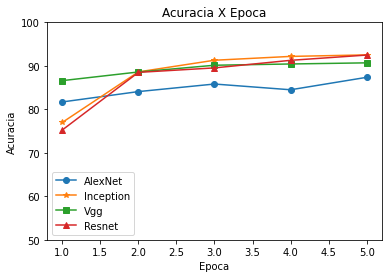

In [ ]:
plota_grafico([81.7 ,84.08 ,85.82 ,84.5 ,87.36],[76.99,88.61,91.29,92.17,92.52],[86.6,88.59,90.14,90.43,90.69],[75.25,88.5,89.53,91.27,92.48])

Utilizando a técnica do Fine Tuning, é possível notar uma melhora geral das acurácias. Dessa vez, na época 5 as redes Vgg, Inception e Resnet apresentaram um resultado muito parecido, mas ainda é possível notar a dominância da Resnet e da Inception. Nesse caso, o melhor resultado foi para Inception, com 92.52 %; o pior, para AlexNet, com 87.36 %. Apesar do resultado inferior, houve uma melhora de 1.4 %

In [ ]:
acuracias_alexnet = []
acuracias_vgg = []
acuracias_resnet = []

3-Finalmente, utilizar as mesmas redes, mas agora FromScratch, i.e., vocês colocaram o flag pretrained=False e treinarão as redes desde o início sem qualquer pré-treino. Plotar seus resultados de acurácia para CIFAR10.


In [ ]:
alexnet = modelo('AlexNet', False)
aprendizado(alexnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoca [1/5], Passo [100/782] Loss: 2.3048
Epoca [1/5], Passo [200/782] Loss: 2.3044
Epoca [1/5], Passo [300/782] Loss: 2.2997
Epoca [1/5], Passo [400/782] Loss: 2.3037
Epoca [1/5], Passo [500/782] Loss: 2.3036
Epoca [1/5], Passo [600/782] Loss: 2.3035
Epoca [1/5], Passo [700/782] Loss: 2.3025
Acuracia do modelo AlexNet: 11.1 %
Epoca [2/5], Passo [100/782] Loss: 2.3019
Epoca [2/5], Passo [200/782] Loss: 2.3022
Epoca [2/5], Passo [300/782] Loss: 2.3015
Epoca [2/5], Passo [400/782] Loss: 2.3024
Epoca [2/5], Passo [500/782] Loss: 2.3019
Epoca [2/5], Passo [600/782] Loss: 2.3042
Epoca [2/5], Passo [700/782] Loss: 2.3012
Acuracia do modelo AlexNet: 18.01 %
Epoca [3/5], Passo [100/782] Loss: 2.3044
Epoca [3/5], Passo [200/782] Loss: 2.3011
Epoca [3/5], Passo [300/782] Loss: 2.3016
Epoca [3/5], Passo [400/782] Loss: 2.3016
Epoca [3/5], Passo [500/782] Loss: 2.3006
Epoca [3/5], Passo [600/782] Loss: 2.3004
Epoca [3/5], Passo [700/782] Loss: 2.3002
Acuracia do modelo AlexNet: 17.82 %
Epoca [4/5]

In [ ]:
inception = modelo('Inception v3', False)
aprendizado(inception)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoca [1/5], Passo [100/782] Loss: 7.7468
Epoca [1/5], Passo [200/782] Loss: 6.0037
Epoca [1/5], Passo [300/782] Loss: 4.8324
Epoca [1/5], Passo [400/782] Loss: 3.3984
Epoca [1/5], Passo [500/782] Loss: 3.3289
Epoca [1/5], Passo [600/782] Loss: 3.9736
Epoca [1/5], Passo [700/782] Loss: 3.4410
Acuracia do modelo Inception3: 20.72 %
Epoca [2/5], Passo [100/782] Loss: 2.2857
Epoca [2/5], Passo [200/782] Loss: 2.6144
Epoca [2/5], Passo [300/782] Loss: 2.1486
Epoca [2/5], Passo [400/782] Loss: 1.9671
Epoca [2/5], Passo [500/782] Loss: 1.9848
Epoca [2/5], Passo [600/782] Loss: 2.0252
Epoca [2/5], Passo [700/782] Loss: 1.8733
Acuracia do modelo Inception3: 24.29 %
Epoca [3/5], Passo [100/782] Loss: 1.9140
Epoca [3/5], Passo [200/782] Loss: 2.0935
Epoca [3/5], Passo [300/782] Loss: 2.2182
Epoca [3/5], Passo [400/782] Loss: 2.1574
Epoca [3/5], Passo [500/782] Loss: 1.9294
Epoca [3/5], Passo [600/782] Loss: 1.9138
Epoca [3/5], Passo [700/782] Loss: 1.8264
Acuracia do modelo Inception3: 26.41 %
E

In [ ]:
vgg = modelo('Vgg16', False)
aprendizado(vgg)

Epoca [1/5], Passo [100/782] Loss: 2.3045
Epoca [1/5], Passo [200/782] Loss: 2.2950
Epoca [1/5], Passo [300/782] Loss: 2.3127
Epoca [1/5], Passo [400/782] Loss: 2.2753
Epoca [1/5], Passo [500/782] Loss: 2.2856
Epoca [1/5], Passo [600/782] Loss: 2.3006
Epoca [1/5], Passo [700/782] Loss: 2.2116
Acuracia do modelo VGG: 22.84 %
Epoca [2/5], Passo [100/782] Loss: 2.1697
Epoca [2/5], Passo [200/782] Loss: 2.0075
Epoca [2/5], Passo [300/782] Loss: 1.9562
Epoca [2/5], Passo [400/782] Loss: 1.9172
Epoca [2/5], Passo [500/782] Loss: 1.9296
Epoca [2/5], Passo [600/782] Loss: 1.8898
Epoca [2/5], Passo [700/782] Loss: 1.8714
Acuracia do modelo VGG: 33.46 %
Epoca [3/5], Passo [100/782] Loss: 1.7141
Epoca [3/5], Passo [200/782] Loss: 1.7603
Epoca [3/5], Passo [300/782] Loss: 1.8567
Epoca [3/5], Passo [400/782] Loss: 1.6733
Epoca [3/5], Passo [500/782] Loss: 1.7936
Epoca [3/5], Passo [600/782] Loss: 1.3832
Epoca [3/5], Passo [700/782] Loss: 1.7362
Acuracia do modelo VGG: 28.01 %
Epoca [4/5], Passo [10

In [ ]:
resnet = modelo('ResNet18', False)
aprendizado(resnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoca [1/5], Passo [100/782] Loss: 2.2651
Epoca [1/5], Passo [200/782] Loss: 2.1138
Epoca [1/5], Passo [300/782] Loss: 2.1380
Epoca [1/5], Passo [400/782] Loss: 2.1196
Epoca [1/5], Passo [500/782] Loss: 2.0262
Epoca [1/5], Passo [600/782] Loss: 2.0253
Epoca [1/5], Passo [700/782] Loss: 1.9198
Acuracia do modelo ResNet: 31.65 %
Epoca [2/5], Passo [100/782] Loss: 1.8875
Epoca [2/5], Passo [200/782] Loss: 1.7232
Epoca [2/5], Passo [300/782] Loss: 1.8389
Epoca [2/5], Passo [400/782] Loss: 1.8878
Epoca [2/5], Passo [500/782] Loss: 1.6529
Epoca [2/5], Passo [600/782] Loss: 1.9116
Epoca [2/5], Passo [700/782] Loss: 1.6325
Acuracia do modelo ResNet: 29.6 %
Epoca [3/5], Passo [100/782] Loss: 1.6196
Epoca [3/5], Passo [200/782] Loss: 1.6094
Epoca [3/5], Passo [300/782] Loss: 1.5826
Epoca [3/5], Passo [400/782] Loss: 1.5238
Epoca [3/5], Passo [500/782] Loss: 1.4932
Epoca [3/5], Passo [600/782] Loss: 1.4505
Epoca [3/5], Passo [700/782] Loss: 1.4754
Acuracia do modelo ResNet: 30.19 %
Epoca [4/5], P

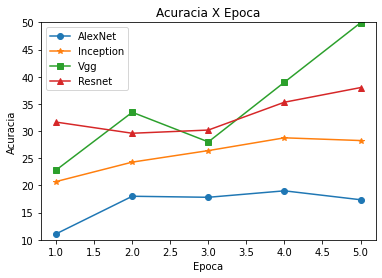

In [ ]:
plota_grafico([11.1,18.01,17.82,19.01,17.37],[20.72,24.29,26.41,28.76,28.26],[22.84,33.46,28.01,38.99,49.92],[31.65,29.6,30.19,35.31,38.0])

Aqui, em um cenário onde não há pré treino, vemos um destaque da rede VGG sobre as outras, com uma acurácia de 49.92 %. É perceptível a falta do pré treino sobre os resultados afetando principalmente a AlexNet, que obteve uma acurácia máxima de 19.01 %, uma diferença de -163 % sobre o melhor resultado.